In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
from dataprep.eda import plot, plot_correlation, plot_missing, create_report
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

In [37]:
df = pd.read_excel("Airlines+Data.xlsx")
print('Shape of the data',df.shape)
df.head(10)

Shape of the data (96, 2)


Month  Passengers
0 1995-01-01         112
1 1995-02-01         118
2 1995-03-01         132
3 1995-04-01         129
4 1995-05-01         121
5 1995-06-01         135
6 1995-07-01         148
7 1995-08-01         148
8 1995-09-01         136
9 1995-10-01         119

In [38]:
df.isnull().any()

Month         False
Passengers    False
dtype: bool

In [39]:
df.shape

(96, 2)

In [40]:
#Checking the data types
df.dtypes

Month         datetime64[ns]
Passengers             int64
dtype: object

In [41]:
#Unique values for every feature
df.nunique()

Month         96
Passengers    80
dtype: int64

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [43]:
df[df.duplicated()].shape

(0, 2)

In [44]:
df[df.duplicated()]

Empty DataFrame
Columns: [Month, Passengers]
Index: []

In [45]:
# Descriptive Analysis
df.describe()

Passengers
count   96.000000
mean   213.708333
std     71.918216
min    104.000000
25%    156.000000
50%    200.000000
75%    264.750000
max    413.000000

In [46]:
# Renaming the Month column into Date
df.rename({'Month':'Date'},axis=1, inplace=True)

In [47]:
# Making the Date as DateTime index for the Dataframe
df1 = df.copy()
df1.set_index('Date',inplace=True)
df1.index.year

Int64Index([1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995,
            1995, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996,
            1996, 1996, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997,
            1997, 1997, 1997, 1998, 1998, 1998, 1998, 1998, 1998, 1998, 1998,
            1998, 1998, 1998, 1998, 1999, 1999, 1999, 1999, 1999, 1999, 1999,
            1999, 1999, 1999, 1999, 1999, 2000, 2000, 2000, 2000, 2000, 2000,
            2000, 2000, 2000, 2000, 2000, 2000, 2001, 2001, 2001, 2001, 2001,
            2001, 2001, 2001, 2001, 2001, 2001, 2001, 2002, 2002, 2002, 2002,
            2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002],
           dtype='int64', name='Date')

In [48]:
df1.head()

Passengers
Date                  
1995-01-01         112
1995-02-01         118
1995-03-01         132
1995-04-01         129
1995-05-01         121

In [49]:
# Separating Month and Year into Separate Column for Visualization and removing meaningful insight of the data
df["Date"] = pd.to_datetime(df.Date,format="%b-%y")
df["month"] = df.Date.dt.strftime("%b") # month extraction
df["year"] = df.Date.dt.strftime("%Y") # year extraction
df.head(10)

Date  Passengers month  year
0 1995-01-01         112   Jan  1995
1 1995-02-01         118   Feb  1995
2 1995-03-01         132   Mar  1995
3 1995-04-01         129   Apr  1995
4 1995-05-01         121   May  1995
5 1995-06-01         135   Jun  1995
6 1995-07-01         148   Jul  1995
7 1995-08-01         148   Aug  1995
8 1995-09-01         136   Sep  1995
9 1995-10-01         119   Oct  1995

# Visualization

<AxesSubplot:xlabel='month', ylabel='year'>

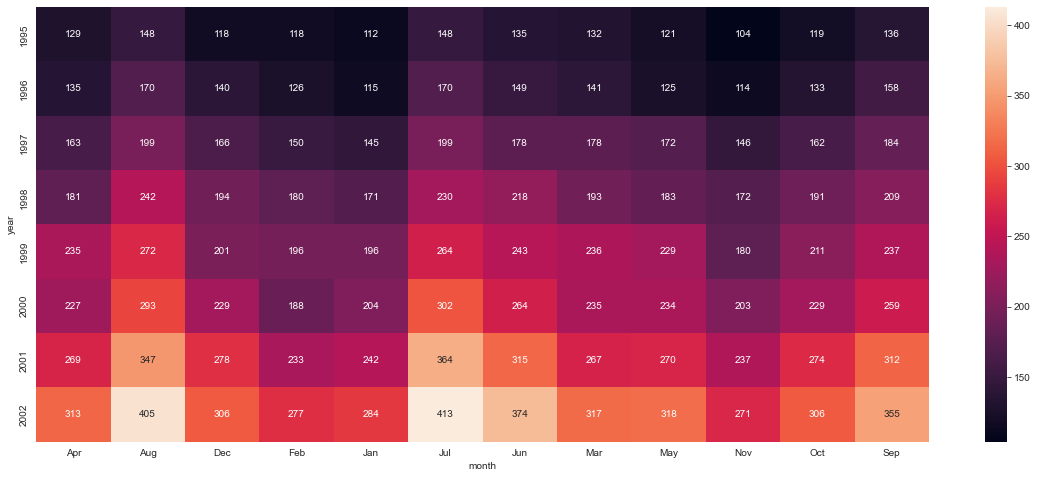

In [50]:
plt.figure(figsize=(20,8))
heatmap_y_month = pd.pivot_table(data=df,values="Passengers",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g") 

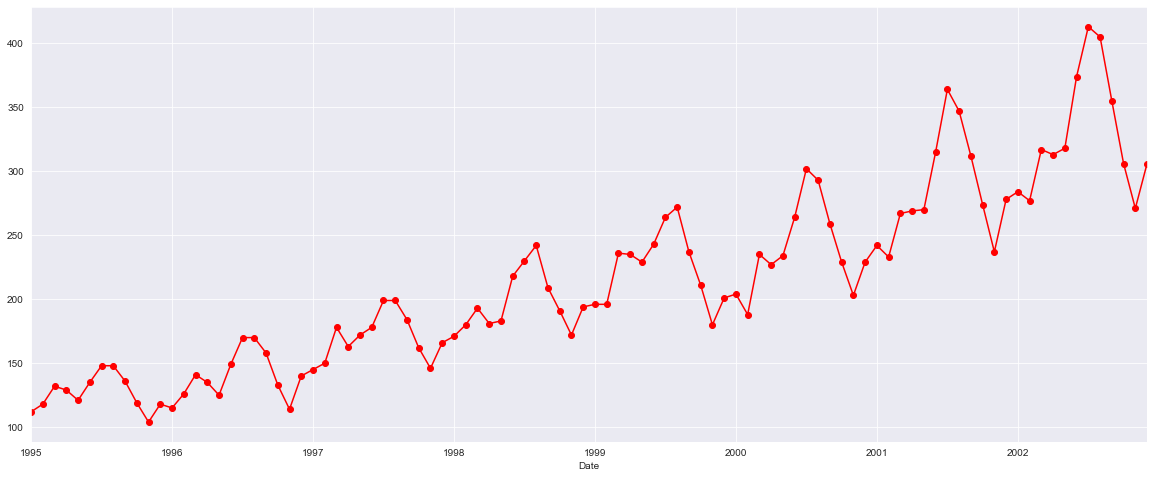

In [51]:
# Line plot
df1['Passengers'].plot(figsize=(20, 8),color='red',marker='o')
plt.show()

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


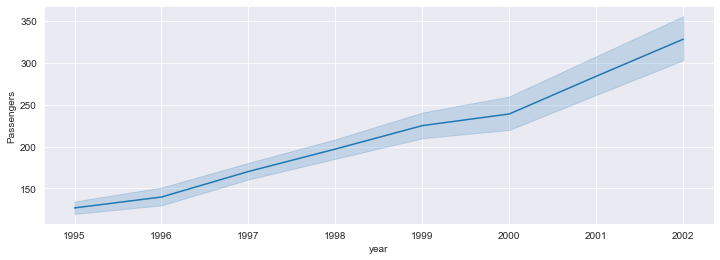

In [52]:
# Yearly Passenger Analysis
plt.figure(figsize=(12,4))
sns.lineplot(x="year",y="Passengers",data=df)
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

<AxesSubplot:xlabel='year', ylabel='Passengers'>

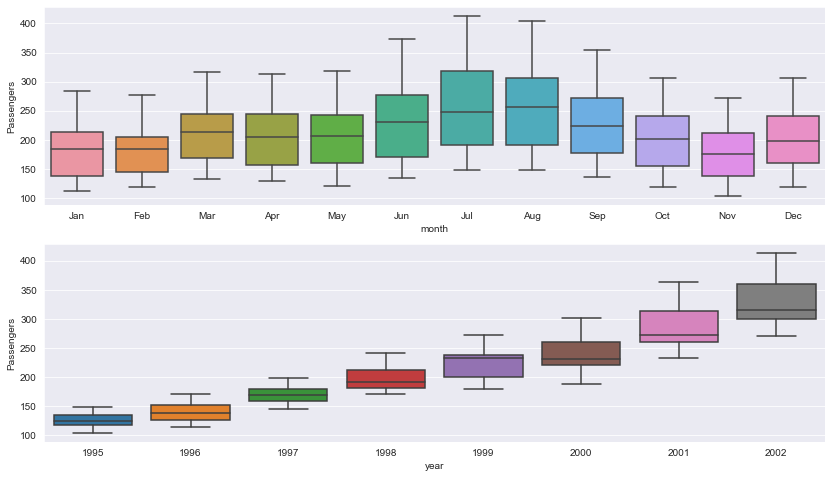

In [53]:
# Box Plot of Each Year by Monthly Intervals
plt.figure(figsize=(14,8))
plt.subplot(211)
sns.boxplot(x="month",y="Passengers",data=df)
plt.subplot(212)
sns.boxplot(x="year",y="Passengers",data=df)

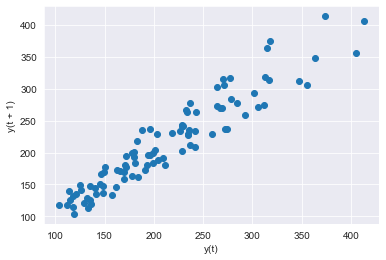

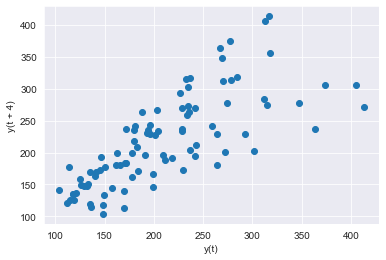

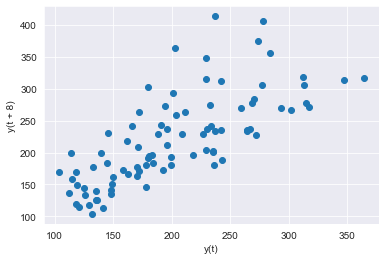

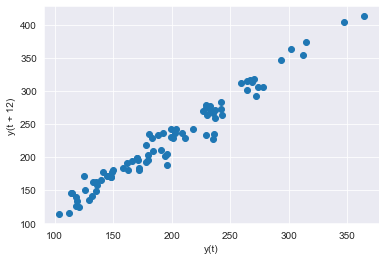

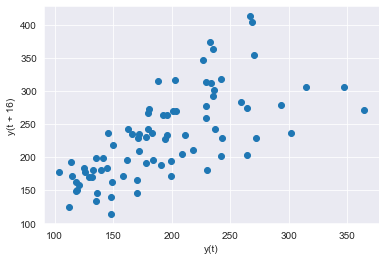

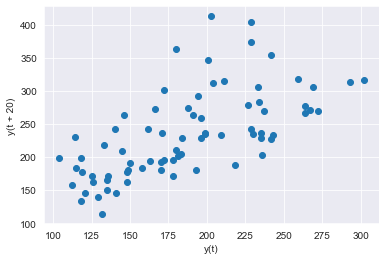

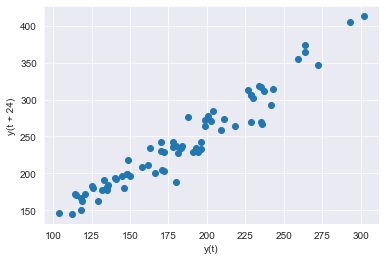

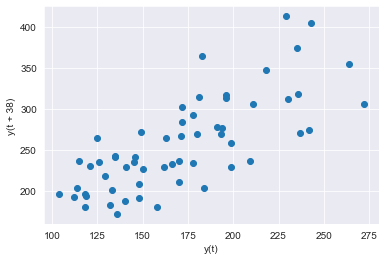

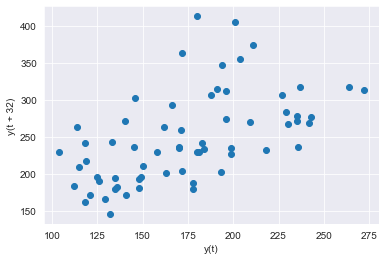

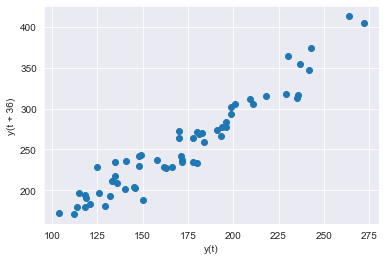

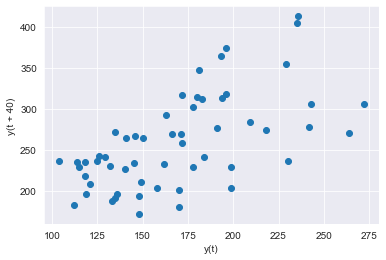

In [54]:
# create a scatter plot
for i in [1, 4, 8, 12, 16, 20, 24, 38, 32, 36, 40]:
    #plt.figure(figsize=(12,8))
    lag_plot(df.Passengers, lag=i)
    plt.show()

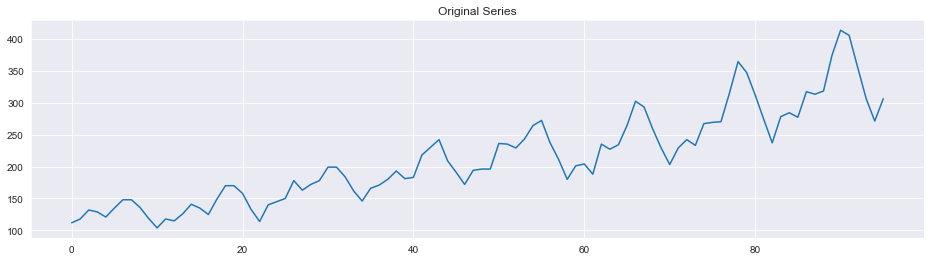

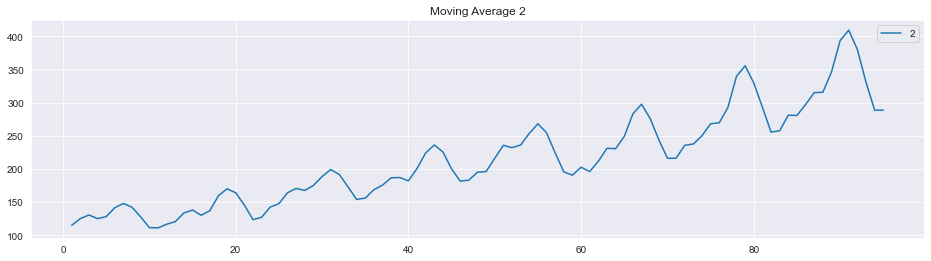

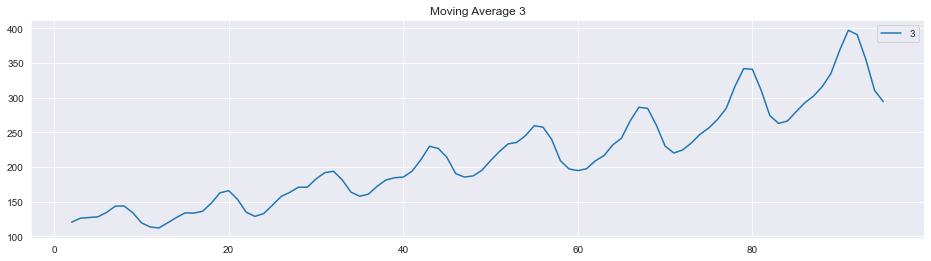

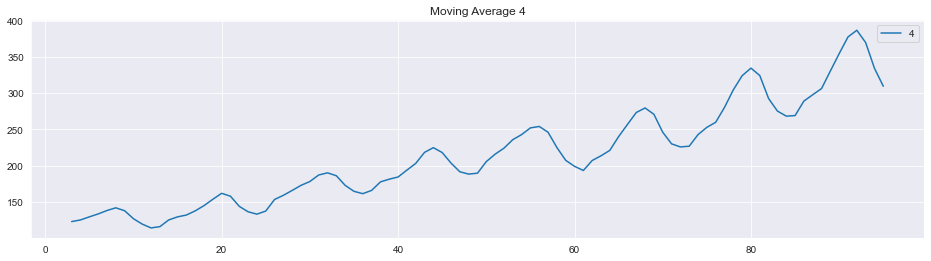

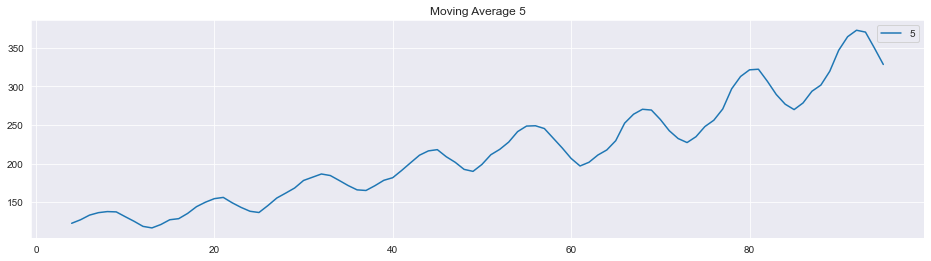

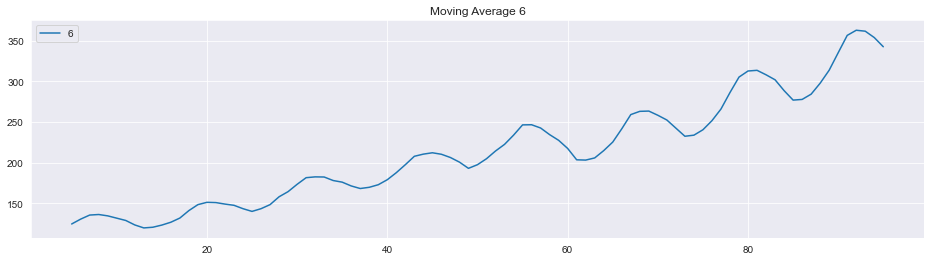

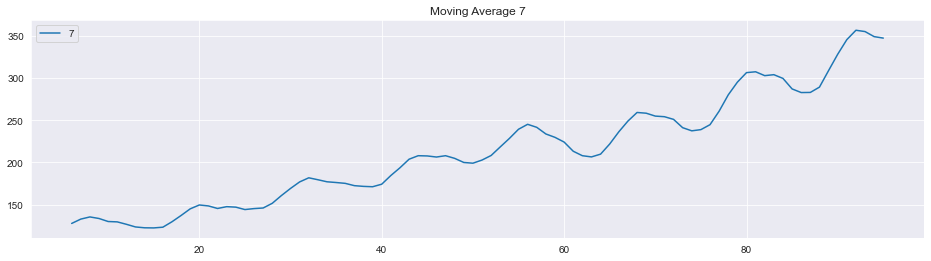

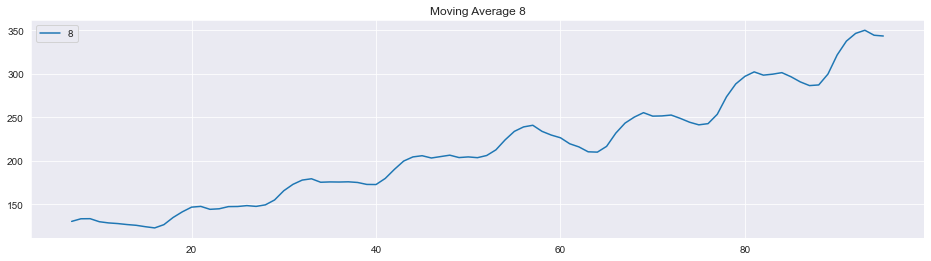

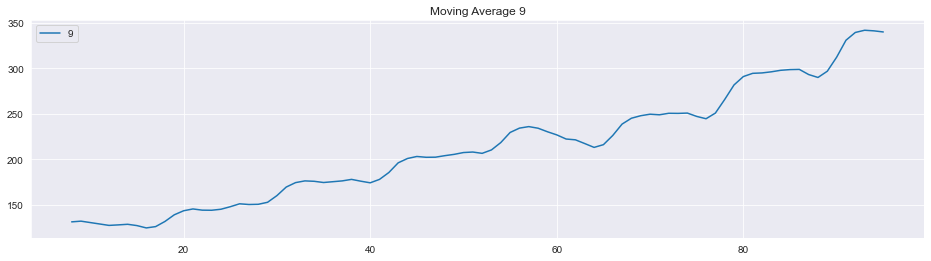

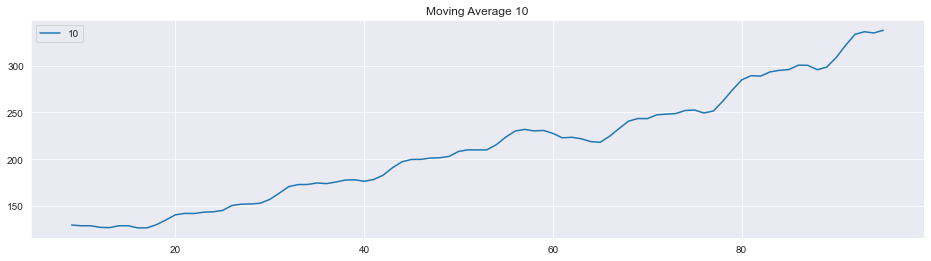

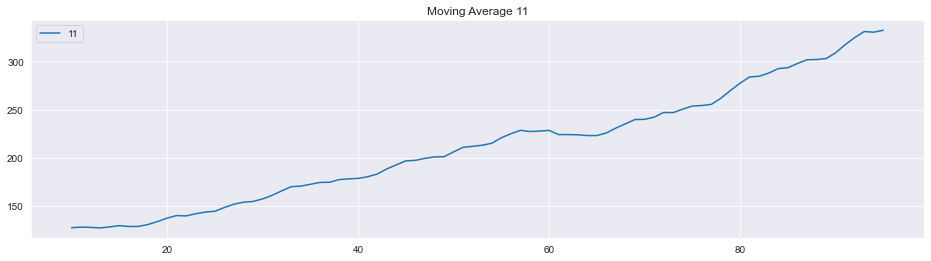

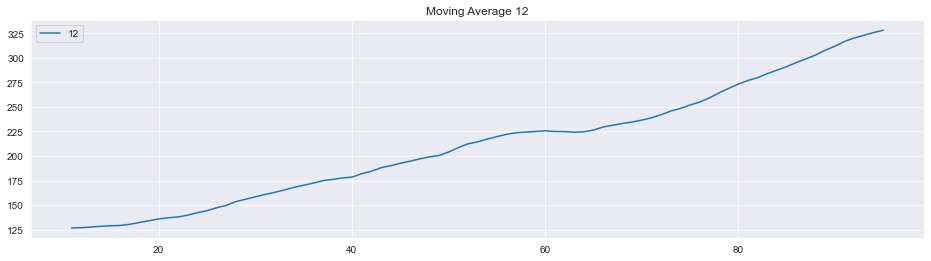

In [55]:
plt.figure(figsize=(16,4))
df.Passengers.plot(label="org")
plt.title("Original Series")
for i in range(2,13):
    plt.figure(figsize=(16,4))
    df["Passengers"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()

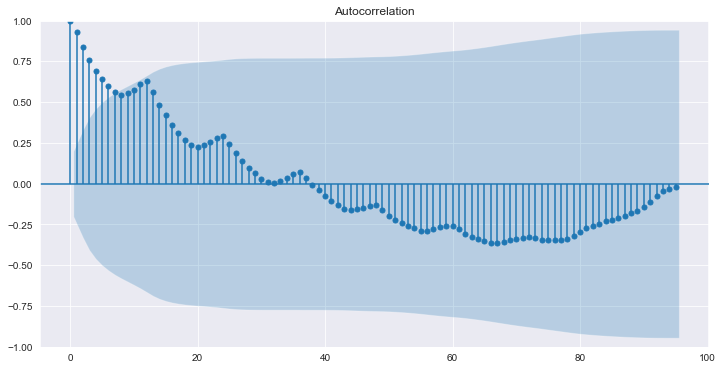

In [56]:
# ACF(Autocorrelation function) plots and PACF(Partial Auto correlation function) plots
# ACF
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,6))
    tsa_plots.plot_acf(df.Passengers,lags=95)
    plt.show()


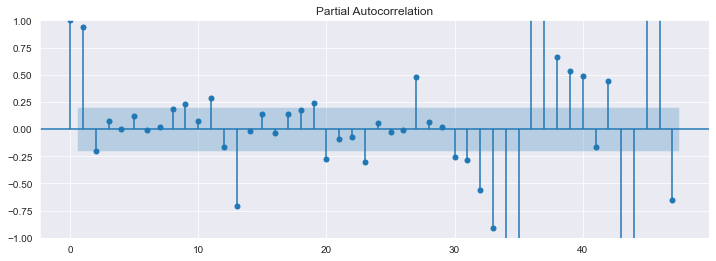

In [57]:
# PACF
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,4))
    tsa_plots.plot_pacf(df.Passengers,lags=47)
    plt.show()


In [58]:
visual = df1.copy()
visual.reset_index(inplace=True)
visual['date'] = pd.to_datetime(visual['Date'])
visual['year'] = visual['Date'].dt.year
visual['month'] = visual['Date'].dt.month
visual['week'] = visual['Date'].dt.isocalendar().week
visual['quarter'] = visual['Date'].dt.quarter
visual['day_of_week'] = visual['Date'].dt.day_name()
visual.drop('Date', axis =1 , inplace= True)
visual.head(10)

Passengers       date  year  month  week  quarter day_of_week
0         112 1995-01-01  1995      1    52        1      Sunday
1         118 1995-02-01  1995      2     5        1   Wednesday
2         132 1995-03-01  1995      3     9        1   Wednesday
3         129 1995-04-01  1995      4    13        2    Saturday
4         121 1995-05-01  1995      5    18        2      Monday
5         135 1995-06-01  1995      6    22        2    Thursday
6         148 1995-07-01  1995      7    26        3    Saturday
7         148 1995-08-01  1995      8    31        3     Tuesday
8         136 1995-09-01  1995      9    35        3      Friday
9         119 1995-10-01  1995     10    39        4      Sunday

In [59]:
visual.year.unique()

array([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002], dtype=int64)

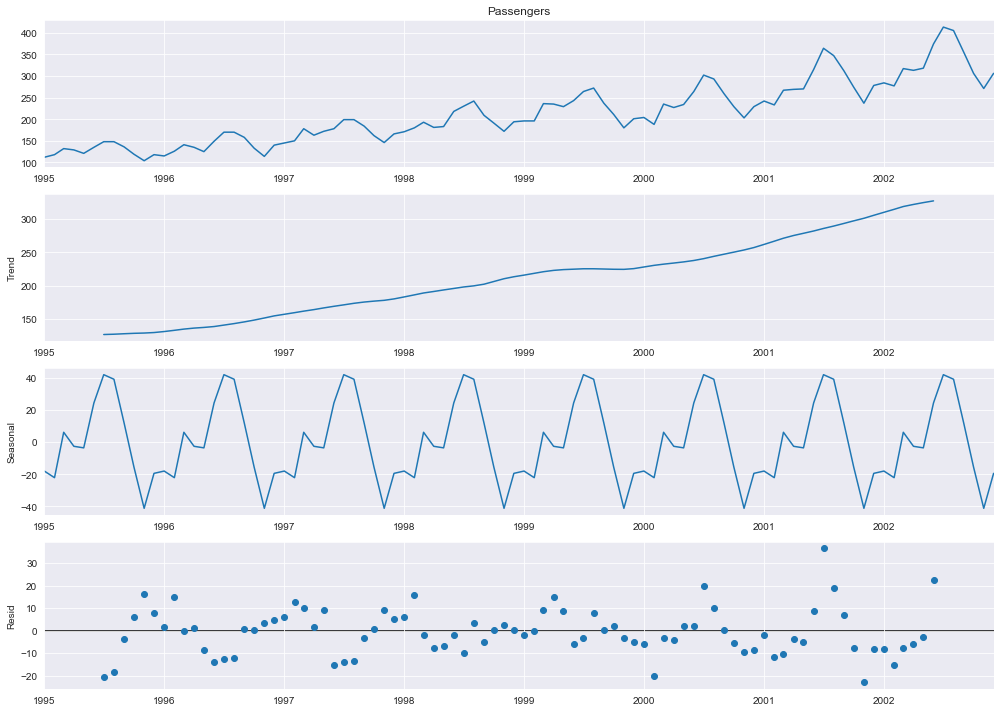

In [60]:
# Additive Seasonal Decomposition
decompose_ts_add = seasonal_decompose(df1.Passengers,period=12, model='additive')
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

# Splitting Train and Test Data
# Leaving Test Data with 2 Years of Time Series

In [61]:
size = 72
train_data = df1[:size]
test_data = df1[size:]

In [62]:
print('Train:',train_data.index.min(),train_data.index.max(),'\n',
'Test:',test_data.index.min(),test_data.index.max())

Train: 1995-01-01 00:00:00 2000-12-01 00:00:00 
 Test: 2001-01-01 00:00:00 2002-12-01 00:00:00


<AxesSubplot:xlabel='Date'>

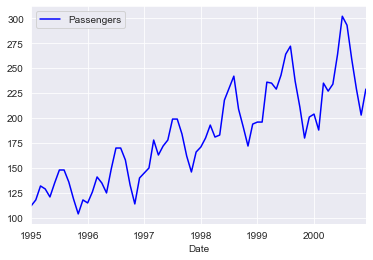

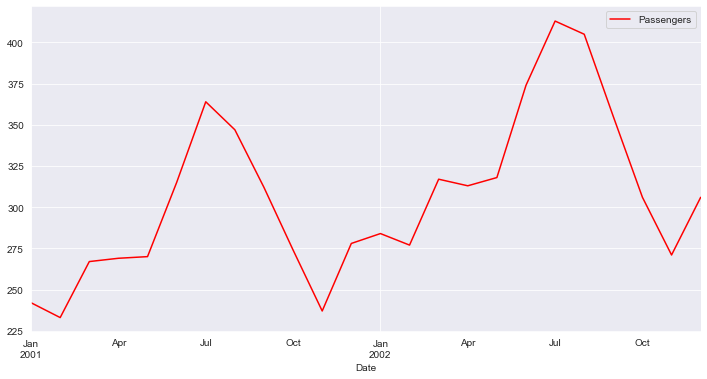

In [63]:
train_data.plot(legend=True,label='TRAIN',color='blue')
test_data.plot(legend=True,label='TEST', figsize=(12,6),color='red')

In [64]:
# Evaluation Metric MAPE
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

# Exponential Methods

In [65]:
# Simple Exponential Method
# Using Forecast Attribute
ses_model = SimpleExpSmoothing(train_data['Passengers']).fit(optimized=True)
test_pred_ses = ses_model.forecast(24)
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = sqrt(mean_squared_error(test_pred_ses,test_data.Passengers))
train_rmse_ses = sqrt(mean_squared_error(train_pred_ses,train_data))
mape_ses = MAPE(test_pred_ses,test_data.Passengers)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ses),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ses))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 23.38228335004595 
 Train Root Mean Squared Error = 19.03177173091145 
 Test Root Mean Squared Error = 91.11325402904713


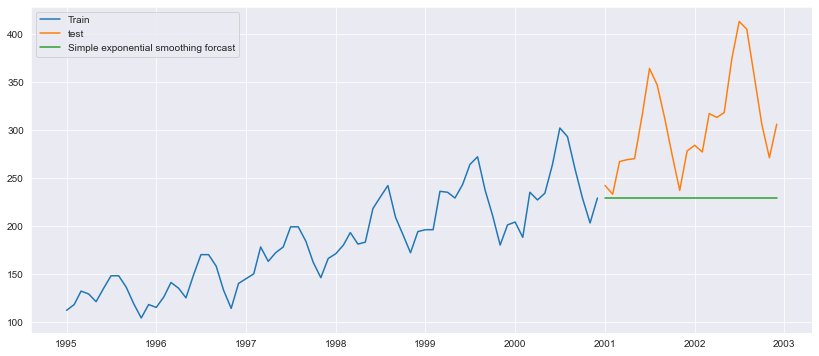

In [66]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

In [67]:
# Holt method (Double Exponential) 
# Captures both Level and Trend
dexp_model  = Holt(train_data).fit(optimized=True)
test_pred_dexp = dexp_model.forecast(24)
train_pred_dexp = dexp_model.fittedvalues
test_rmse_dexp = sqrt(mean_squared_error(test_pred_dexp,test_data.Passengers))
train_rmse_dexp = sqrt(mean_squared_error(train_pred_dexp,train_data))
mape_dexp = MAPE(test_pred_dexp,test_data.Passengers)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_dexp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_dexp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_dexp))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 17.149025584030046 
 Train Root Mean Squared Error = 18.961289994538912 
 Test Root Mean Squared Error = 71.6347776288056


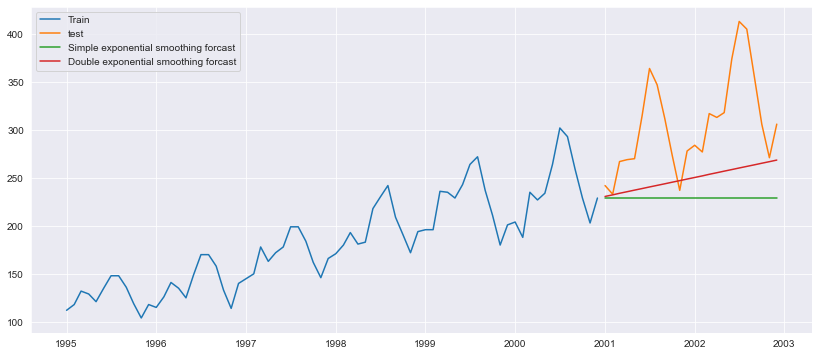

In [68]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

In [69]:
# Holts winter exponential smoothing with additive seasonality and trend (Triple Exponential)
# Captures Level, Trend and Seasonality.
texp_add_model  = ExponentialSmoothing(train_data,seasonal="add",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_ad_texp = texp_add_model.forecast(24)
train_pred_ad_texp = texp_add_model.fittedvalues
test_rmse_ad_texp = sqrt(mean_squared_error(test_pred_ad_texp,test_data.Passengers))
train_rmse_ad_texp = sqrt(mean_squared_error(train_pred_ad_texp,train_data))
mape_ad_texp = MAPE(test_pred_ad_texp,test_data.Passengers)
print('Triple Exponential with Additive Trend and Seosonality Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_texp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ad_texp))

Triple Exponential with Additive Trend and Seosonality Method Evaluation 
 Mean Absolute Percent Error = 12.084270987248688 
 Train Root Mean Squared Error = 7.751303510644329 
 Test Root Mean Squared Error = 47.56853148096913


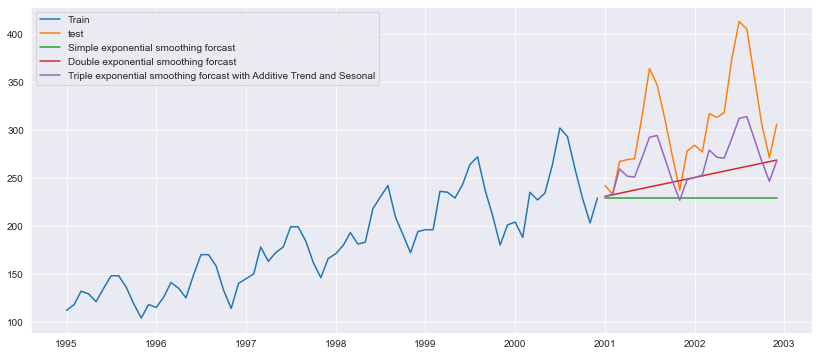

In [70]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.legend(loc='best')
plt.show()

In [72]:
texp_mul_ad_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_mul_ad_texp = texp_mul_ad_model.forecast(24)
train_pred_mul_ad_texp = texp_mul_ad_model.fittedvalues
test_rmse_mul_ad_texp = sqrt(mean_squared_error(test_pred_mul_ad_texp,test_data.Passengers))
train_rmse_mul_ad_texp = sqrt(mean_squared_error(train_pred_mul_ad_texp,train_data))
mape_mul_ad_texp = MAPE(test_pred_mul_ad_texp,test_data.Passengers)
print('Triple Exponential Method with Multiplicative Seasonality and Additive Trend',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_mul_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_ad_texp),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_mul_ad_texp))

Triple Exponential Method with Multiplicative Seasonality and Additive Trend 
 Mean Absolute Percent Error = 9.368507048672798 
 Train Root Mean Squared Error = 6.386634437545614 
 Test Root Mean Squared Error = 34.989900508860515


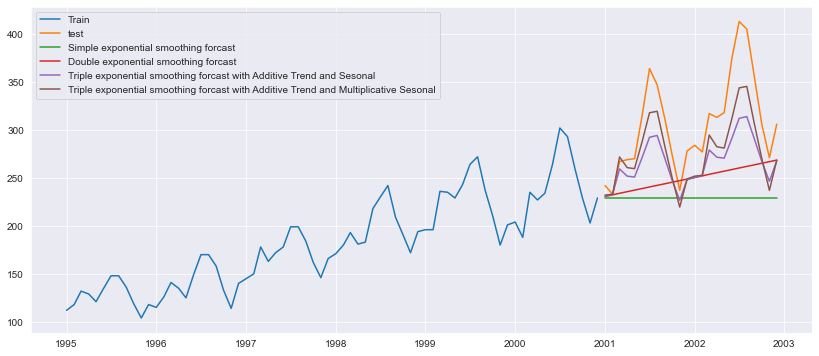

In [73]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.legend(loc='best')
plt.show()

In [84]:
#Comparing the results 

Evaluation = {"Models":pd.Series(["Simple_Exp","Double_Exp","Triple_Exp_ad"\
                                  ,"Triple_Exp_mul_ad"]),\
        "Train_RMSE":pd.Series([train_rmse_ses,train_rmse_dexp,train_rmse_ad_texp,train_rmse_mul_ad_texp]),\
        "Test_MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp]),\
        "Test_RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['Test_MAPE(%)'], inplace=True, ignore_index=True)
table_evaluation

Models  Train_RMSE  Test_MAPE(%)  Test_RMSE_Values
0  Triple_Exp_mul_ad    6.386634      9.368507         34.989901
1      Triple_Exp_ad    7.751304     12.084271         47.568531
2         Double_Exp   18.961290     17.149026         71.634778
3         Simple_Exp   19.031772     23.382283         91.113254

# Visualizing Models Performance

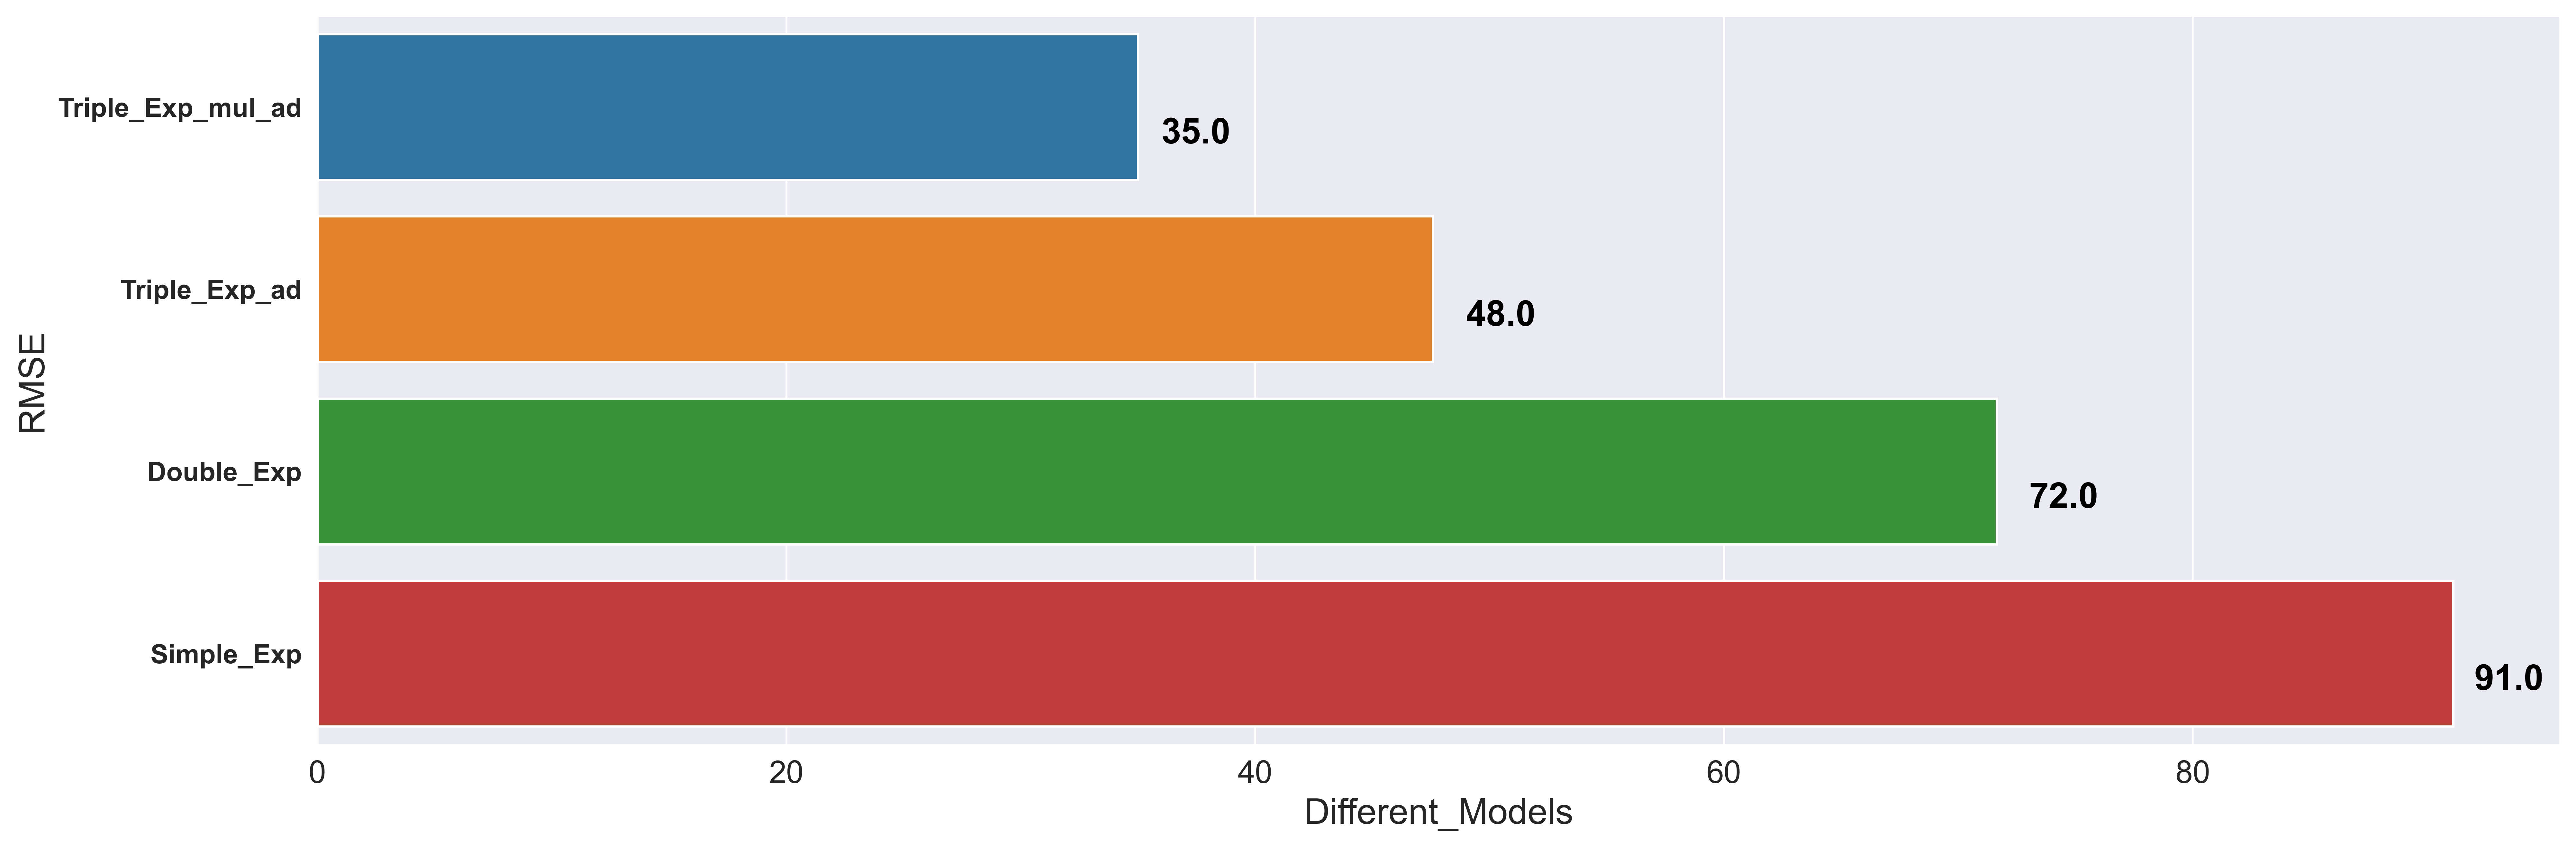

In [85]:
f, axe = plt.subplots(1,1, figsize=(18,6), dpi=500)
sns.barplot(x='Test_RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)


for i, v in enumerate(np.round(table_evaluation.Test_RMSE_Values.values,0)):
    axe.text(v + 1, i + .20, str(v),
            color = 'black', fontweight = 'bold', fontsize= 16)

plt.show()

# Autoregressive Integrated Moving Averages (ARIMA)
# Stationary vs Non-stationary Time Series

In [86]:
# Test of Stationarity
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=4).mean()
    movingSTD = timeseries.rolling(window=4).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

# Augmented Dickey Fuller Test

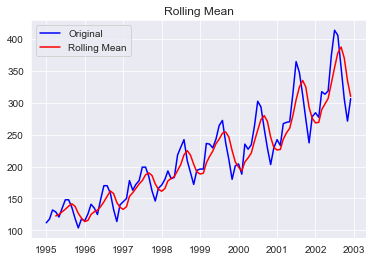

Results of Dickey Fuller Test:
Test Statistic                  1.340248
p-value                         0.996825
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [87]:
sales= pd.DataFrame()
sales['Passengers'] = df1[['Passengers']]
test_stationarity(sales)

In [88]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):    
    result = adfuller(series.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [89]:
adf_test(sales)

Fail to reject the null hypothesis
Data is non-stationary


In [ ]:
# Feature Scaling (Transformations)

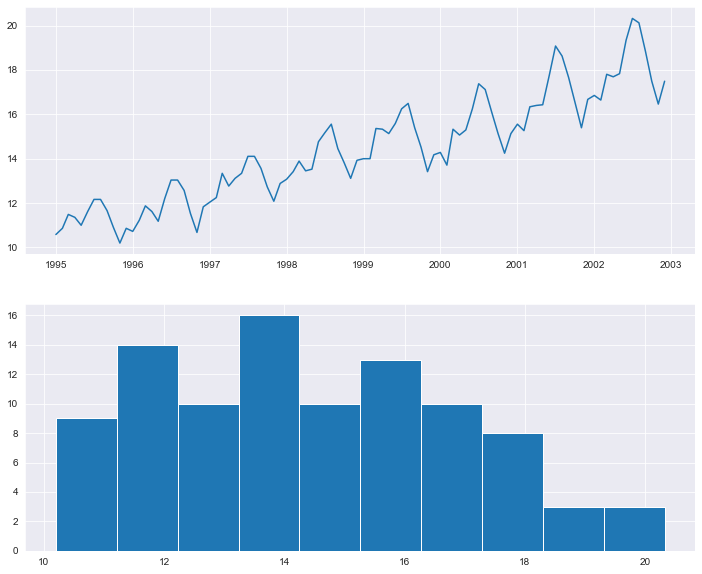

In [90]:
# Square Root Transform
square_root= pd.DataFrame()
square_root = df1[['Passengers']]
square_root['Passengers'] = np.sqrt(square_root.Passengers)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(square_root['Passengers'])
#Histogram
plt.subplot(212)
plt.hist(square_root['Passengers'])
plt.show()

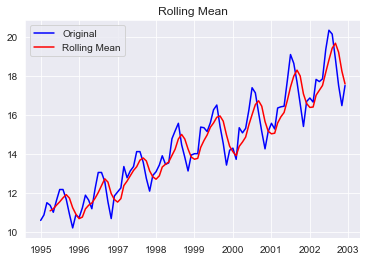

Results of Dickey Fuller Test:
Test Statistic                  0.451435
p-value                         0.983320
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [91]:
test_stationarity(square_root)

In [92]:
adf_test(square_root)

Fail to reject the null hypothesis
Data is non-stationary


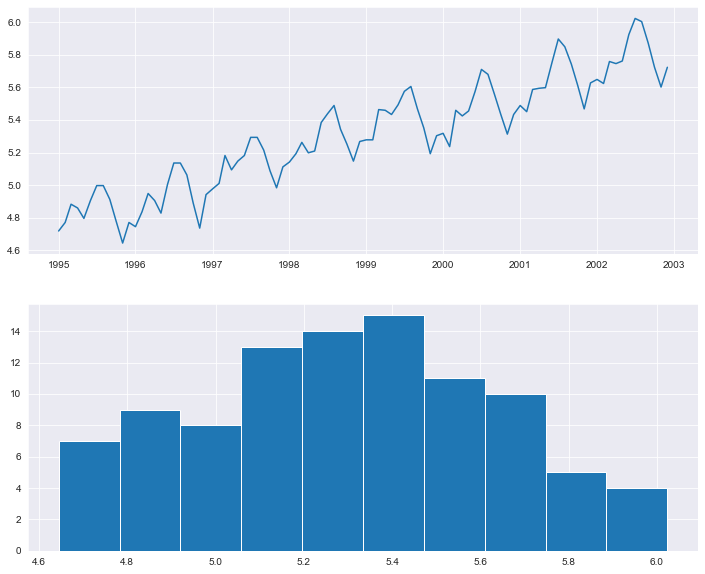

In [93]:
# Log Transform
log = pd.DataFrame()
log = df1[['Passengers']]
log['Passengers'] = np.log(log.Passengers)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(log['Passengers'])
#Histogram
plt.subplot(212)
plt.hist(log['Passengers'])
plt.show()

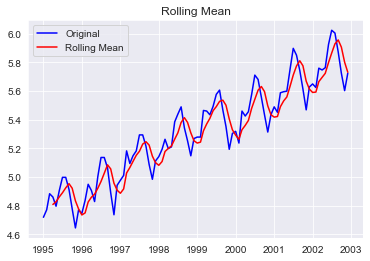

Results of Dickey Fuller Test:
Test Statistic                 -0.723027
p-value                         0.840695
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [94]:
test_stationarity(log)

In [95]:
adf_test(log)

Fail to reject the null hypothesis
Data is non-stationary


# Converting Non-Stationary Time Series into Stationary

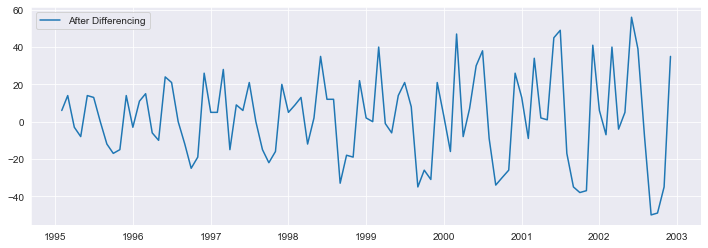

In [96]:
# Differencing
differencing = df1 - df1.shift(1)
differencing.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(differencing, label='After Differencing')
plt.legend(loc='best')
plt.show()

Passengers
Date                  
1995-01-01    4.718499
1995-02-01    4.770685
1995-03-01    4.882802
1995-04-01    4.859812
1995-05-01    4.795791

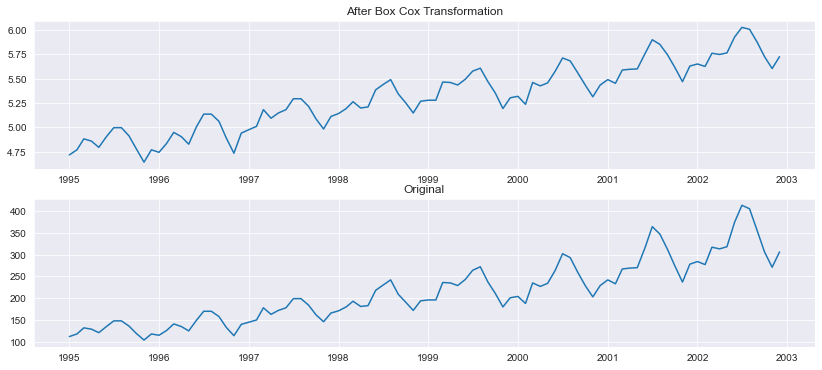

In [97]:
# Box Cox Transformation
data_boxcox = pd.DataFrame()
data_boxcox['Passengers'] = pd.Series(boxcox(df1['Passengers'], lmbda=0), df1.index)
display(data_boxcox.head())
fig, axis = plt.subplots(2,figsize=(14,6),)
axis[0].plot(data_boxcox)
axis[0].set_title('After Box Cox Transformation')
axis[1].plot(df1, label='original')
axis[1].set_title('Original')
plt.show()

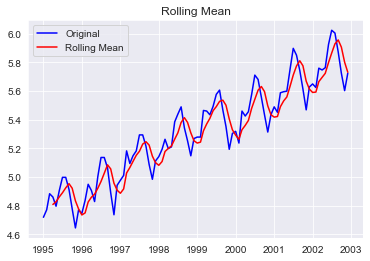

Results of Dickey Fuller Test:
Test Statistic                 -0.723027
p-value                         0.840695
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [98]:
test_stationarity(data_boxcox)

In [99]:
adf_test(data_boxcox)

Fail to reject the null hypothesis
Data is non-stationary


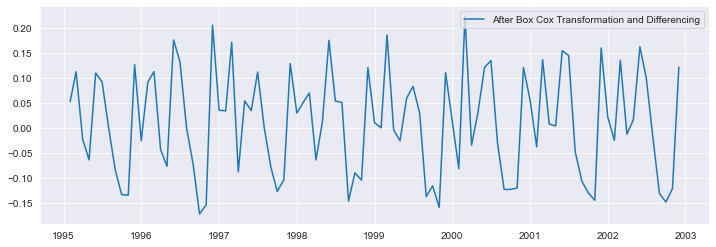

In [100]:
# Differencing of the Box-Cox Transformation
# data_boxcox - data_boxcox.shift() :- Performs difference between the previous and current observations.
#data_boxcox_diff = data_boxcox - data_boxcox.shift()
data_boxcox_diff = data_boxcox - data_boxcox.shift()
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox Transformation and Differencing')
plt.legend(loc='best')
plt.show()

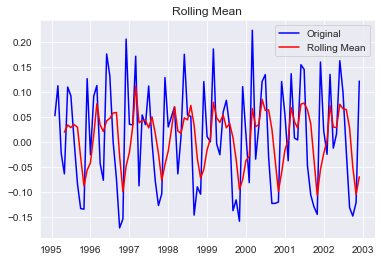

Results of Dickey Fuller Test:
Test Statistic                 -2.670823
p-value                         0.079225
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [101]:
#check this log transfered data with function
test_stationarity(data_boxcox_diff)

In [102]:
adf_test(data_boxcox_diff)

Fail to reject the null hypothesis
Data is non-stationary


In [ ]:
# ARIMA Hyperparameter Tuning

In [103]:
# grid search ARIMA parameters for a time series

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [104]:
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    #print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except Exception as e:
                    print(e)
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [105]:
# Building The Time Series Forecasting with Optimal Value using ARIMA
train_data_boxcox = data_boxcox[:size]
test_data_boxcox = data_boxcox[size:]
train_data_boxcox_diff = data_boxcox_diff[:size]
test_data_boxcox_diff = data_boxcox_diff[size:]

In [106]:
# Inverse transformation of the Box-Cox Differencing 
model = ARIMA(train_data_boxcox_diff, order=(4, 1, 4))
model_fit = model.fit()
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['arima_forecast'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
# We did differencing. So we need to revert it by adding the consecutive observations.
# For that we are using cumsum() method
y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].cumsum()
# We removed the first observations after differencing as it was null. Hence, adding the first observation back.
y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].add(data_boxcox.Passengers[0])
# Now doing the reverse transformation 
# We have done Box Cox Log Log transformation with lambda = 0
# Hence, we have to the exponential as it is the reverse of the log.
y_hat_ar['arima_forecast'] = np.exp(y_hat_ar['arima_forecast'])

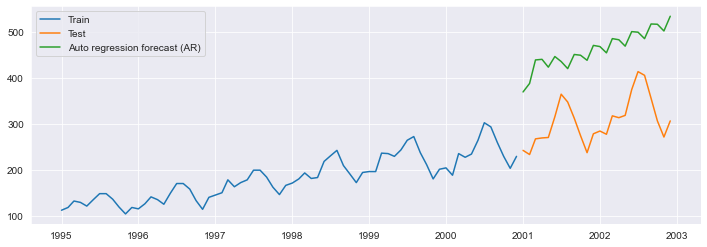

In [107]:
plt.figure(figsize=(12,4))
plt.plot(train_data['Passengers'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_ar['arima_forecast'][test_data.index.min():], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

# Model Evaluation

In [108]:
# RMSE (Root Mean Squared Error)
rmse_ARIMA = np.sqrt(mean_squared_error(test_data, y_hat_ar['arima_forecast'][test_data.index.min():])).round(2)
rmse_ARIMA

161.33

In [109]:
# MAPE (Mean Absolute Percent Error)
mape_arima = round(np.mean(np.abs((test_data.Passengers - y_hat_ar['arima_forecast'][test_data.index.min():])/test_data.Passengers)*100),2)
mape_arima

53.2

In [110]:
# Analysing the Residuals
# The mean of the Residual should be zero or close to Zero
model_residual = model_fit.resid
model_residual.mean()

-0.005854564717745193

In [111]:
# Residuals must be stationary
adf_test(model_residual)

Fail to reject the null hypothesis
Data is non-stationary


# Data Pre-processing for Model Driven Techniques

In [113]:
# Creating Dummy Variables of the Categorical Feature Month of Date Time feature 
cocacola = df1.copy()
cocacola.reset_index(inplace=True)
cocacola['t'] = np.arange(1,len(cocacola)+1)
cocacola['t_squared'] = np.square(cocacola.t)
cocacola["month"] = cocacola.Date.dt.strftime("%b") # month extraction
cocacola["year"] = cocacola.Date.dt.strftime("%Y") # year extraction
months = pd.get_dummies(cocacola['month'])
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
cocacola = pd.concat([cocacola,months],axis=1)
cocacola['log_passengers'] = np.log(cocacola['Passengers'])
cocacola

Date  Passengers   t  t_squared month  year  Jan  Feb  Mar  Apr  May  \
0  1995-01-01         112   1          1   Jan  1995    1    0    0    0    0   
1  1995-02-01         118   2          4   Feb  1995    0    1    0    0    0   
2  1995-03-01         132   3          9   Mar  1995    0    0    1    0    0   
3  1995-04-01         129   4         16   Apr  1995    0    0    0    1    0   
4  1995-05-01         121   5         25   May  1995    0    0    0    0    1   
..        ...         ...  ..        ...   ...   ...  ...  ...  ...  ...  ...   
91 2002-08-01         405  92       8464   Aug  2002    0    0    0    0    0   
92 2002-09-01         355  93       8649   Sep  2002    0    0    0    0    0   
93 2002-10-01         306  94       8836   Oct  2002    0    0    0    0    0   
94 2002-11-01         271  95       9025   Nov  2002    0    0    0    0    0   
95 2002-12-01         306  96       9216   Dec  2002    0    0    0    0    0   

    Jun  Jul  Aug  Sep  Oct  Nov  Dec  log_passengers  
0     0    0    0    0    0    0    0        4.718499  
1     0    0    0    0    0    0    0        4.770685  
2     0    0    0    0    0    0    0        4.882802  
3     0    0    0    0    0    0    0        4.859812  
4     0    0    0    0    0    0    0        4.795791  
..  ...  ...  ...  ...  ...  ...  ...             ...  
91    0    0    1    0    0    0    0        6.003887  
92    0    0    0    1    0    0    0        5.872118  
93    0    0    0    0    1    0    0        5.723585  
94    0    0    0    0    0    1    0        5.602119  
95    0    0    0    0    0    0    1        5.723585  

[96 rows x 19 columns]

In [114]:
# Splitting data into Train and Test 
train_data = cocacola.iloc[:size]
test_data = cocacola.iloc[size:]

In [115]:
train_data
test_data


Date  Passengers   t  t_squared month  year  Jan  Feb  Mar  Apr  May  \
72 2001-01-01         242  73       5329   Jan  2001    1    0    0    0    0   
73 2001-02-01         233  74       5476   Feb  2001    0    1    0    0    0   
74 2001-03-01         267  75       5625   Mar  2001    0    0    1    0    0   
75 2001-04-01         269  76       5776   Apr  2001    0    0    0    1    0   
76 2001-05-01         270  77       5929   May  2001    0    0    0    0    1   
77 2001-06-01         315  78       6084   Jun  2001    0    0    0    0    0   
78 2001-07-01         364  79       6241   Jul  2001    0    0    0    0    0   
79 2001-08-01         347  80       6400   Aug  2001    0    0    0    0    0   
80 2001-09-01         312  81       6561   Sep  2001    0    0    0    0    0   
81 2001-10-01         274  82       6724   Oct  2001    0    0    0    0    0   
82 2001-11-01         237  83       6889   Nov  2001    0    0    0    0    0   
83 2001-12-01         278  84       7056   Dec  2001    0    0    0    0    0   
84 2002-01-01         284  85       7225   Jan  2002    1    0    0    0    0   
85 2002-02-01         277  86       7396   Feb  2002    0    1    0    0    0   
86 2002-03-01         317  87       7569   Mar  2002    0    0    1    0    0   
87 2002-04-01         313  88       7744   Apr  2002    0    0    0    1    0   
88 2002-05-01         318  89       7921   May  2002    0    0    0    0    1   
89 2002-06-01         374  90       8100   Jun  2002    0    0    0    0    0   
90 2002-07-01         413  91       8281   Jul  2002    0    0    0    0    0   
91 2002-08-01         405  92       8464   Aug  2002    0    0    0    0    0   
92 2002-09-01         355  93       8649   Sep  2002    0    0    0    0    0   
93 2002-10-01         306  94       8836   Oct  2002    0    0    0    0    0   
94 2002-11-01         271  95       9025   Nov  2002    0    0    0    0    0   
95 2002-12-01         306  96       9216   Dec  2002    0    0    0    0    0   

    Jun  Jul  Aug  Sep  Oct  Nov  Dec  log_passengers  
72    0    0    0    0    0    0    0        5.488938  
73    0    0    0    0    0    0    0        5.451038  
74    0    0    0    0    0    0    0        5.587249  
75    0    0    0    0    0    0    0        5.594711  
76    0    0    0    0    0    0    0        5.598422  
77    1    0    0    0    0    0    0        5.752573  
78    0    1    0    0    0    0    0        5.897154  
79    0    0    1    0    0    0    0        5.849325  
80    0    0    0    1    0    0    0        5.743003  
81    0    0    0    0    1    0    0        5.613128  
82    0    0    0    0    0    1    0        5.468060  
83    0    0    0    0    0    0    1        5.627621  
84    0    0    0    0    0    0    0        5.648974  
85    0    0    0    0    0    0    0        5.624018  
86    0    0    0    0    0    0    0        5.758902  
87    0    0    0    0    0    0    0        5.746203  
88    0    0    0    0    0    0    0        5.762051  
89    1    0    0    0    0    0    0        5.924256  
90    0    1    0    0    0    0    0        6.023448  
91    0    0    1    0    0    0    0        6.003887  
92    0    0    0    1    0    0    0        5.872118  
93    0    0    0    0    1    0    0        5.723585  
94    0    0    0    0    0    1    0        5.602119  
95    0    0    0    0    0    0    1        5.723585

In [116]:
# Building Ordinary Square Model 
# Linear Model
import statsmodels.formula.api as smf 

linear_model = smf.ols('Passengers~t',data=train_data).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test_data['t'])))
rmse_linear = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_linear))**2))
rmse_linear

51.667792995646266

In [117]:
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Passengers   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     217.9
Date:                Wed, 28 Dec 2022   Prob (F-statistic):           3.50e-23
Time:                        23:12:21   Log-Likelihood:                -329.04
No. Observations:                  72   AIC:                             662.1
Df Residuals:                      70   BIC:                             666.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    110.5243      5.643     19.586      0.000      99.270     121.779
t              1.9830      0.134     14.760      0.000       1.715       2.251
==============================================================================
Omnibus:                        0.634   Durbin-Watson:                   0.659
Prob(Omnibus):                  0.728   Jarque-Bera (JB):                0.667
Skew:                           0.213   Prob(JB):                        0.717
Kurtosis:                       2.799   Cond. No.                         84.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [118]:
#Exponential

Exp = smf.ols('log_passengers~t',data=train_data).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test_data['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

42.552328946004586

In [119]:
Exp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_passengers   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     246.3
Date:                Wed, 28 Dec 2022   Prob (F-statistic):           1.28e-24
Time:                        23:12:37   Log-Likelihood:                 48.708
No. Observations:                  72   AIC:                            -93.42
Df Residuals:                      70   BIC:                            -88.86
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7699      0.030    160.519      0.000       4.711       4.829
t              0.0111      0.001     15.693      0.000       0.010       0.013
==============================================================================
Omnibus:                        2.000   Durbin-Watson:                   0.687
Prob(Omnibus):                  0.368   Jarque-Bera (JB):                1.573
Skew:                          -0.186   Prob(JB):                        0.456
Kurtosis:                       2.378   Cond. No.                         84.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [120]:
#Quadratic 

Quad = smf.ols('Passengers~t+t_squared',data=train_data).fit()
pred_Quad = pd.Series(Quad.predict(test_data[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_Quad))**2))
rmse_Quad

51.990736401555004

In [121]:
#Additive seasonality 

add_sea = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea = pd.Series(add_sea.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_add_sea))**2))
rmse_add_sea

127.26451565320339

In [122]:
#Additive Seasonality Quadratic 

add_sea_Quad = smf.ols('Passengers~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

35.24160848593341

In [123]:
# Multiplicative Seasonality

Mul_sea = smf.ols('log_passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test_data))
rmse_Mult_sea = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

132.18762800263437

In [124]:
# Multiplicative Additive Seasonality 

Mul_Add_sea = smf.ols('log_passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test_data))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(test_data['Passengers'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea 

11.714670246780562

In [127]:
# Compare the results 

data = {"Models":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)
